# Training GameContextMLP (Expert)
This notebook demonstrates the training of the MLP expert model for NFL play prediction. The MLP (Multi-Layer Perceptron) expert focuses on game context features to predict whether a play will be a pass or run.

## Imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np

In [3]:
from experts.mlp import GameContextMLP
from etl.dataloader import ExpertDataset
from torch.utils.data import DataLoader

## Loading Dataset

See `etl` module for more details.

In [4]:
# Make test-train-split
from sklearn.model_selection import train_test_split


df = pd.read_csv('features/target.csv')

# Split into train (80%) and test (20%) sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Reset indices
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [5]:
# create the dataset
MLP_train_dataset = ExpertDataset(df_train, expert_name="mlp")
MLP_val_dataset = ExpertDataset(df_test, expert_name="mlp")

In [6]:
# Get features and targets from dataset
X_train, y_train = MLP_train_dataset.features, MLP_train_dataset.targets
X_val, y_val = MLP_val_dataset.features, MLP_val_dataset.targets

In [7]:
X_train.shape, y_train.shape

((12465, 15), (12465,))

## Training expert
See `experts` module for more details.

**Architecture**
- Input Size: 15 features (game context features)
    - Down, distance, quarter, time remaining, score differential, etc.
- Hidden Layers: 3 layers with 64 units each
- Activation: ReLU
- Output: Single unit with sigmoid activation (binary classification: 1 for pass, 0 for run)

In [8]:
mlp_model = GameContextMLP(input_size=X_train.shape[1])

In [9]:
# Training parameters
n_epochs = 50
batch_size = 32
learning_rate = 0.001

# Create dataloaders
train_loader = DataLoader(MLP_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(MLP_val_dataset, batch_size=batch_size, shuffle=True)

# Train the model and get metrics
train_metrics = mlp_model.train_model(train_loader, val_loader,
                              epochs=n_epochs,
                              learning_rate=learning_rate)

Epoch [1/50], Loss: 0.6750, Accuracy: 60.76%
	 Validation Loss: 0.6686, Validation Accuracy: 61.41%
Epoch [2/50], Loss: 0.6718, Accuracy: 60.80%
	 Validation Loss: 0.6690, Validation Accuracy: 61.41%
Epoch [3/50], Loss: 0.6706, Accuracy: 60.80%
	 Validation Loss: 0.6689, Validation Accuracy: 61.41%
Epoch [4/50], Loss: 0.6708, Accuracy: 60.80%
	 Validation Loss: 0.6730, Validation Accuracy: 61.41%
Epoch [5/50], Loss: 0.6708, Accuracy: 60.80%
	 Validation Loss: 0.6681, Validation Accuracy: 61.41%
Epoch [6/50], Loss: 0.6703, Accuracy: 60.80%
	 Validation Loss: 0.6693, Validation Accuracy: 61.41%
Epoch [7/50], Loss: 0.6698, Accuracy: 60.80%
	 Validation Loss: 0.6688, Validation Accuracy: 61.41%
Epoch [8/50], Loss: 0.6695, Accuracy: 60.80%
	 Validation Loss: 0.6684, Validation Accuracy: 61.41%
Epoch [9/50], Loss: 0.6691, Accuracy: 60.77%
	 Validation Loss: 0.6691, Validation Accuracy: 61.31%
Epoch [10/50], Loss: 0.6689, Accuracy: 60.84%
	 Validation Loss: 0.6704, Validation Accuracy: 61.25%

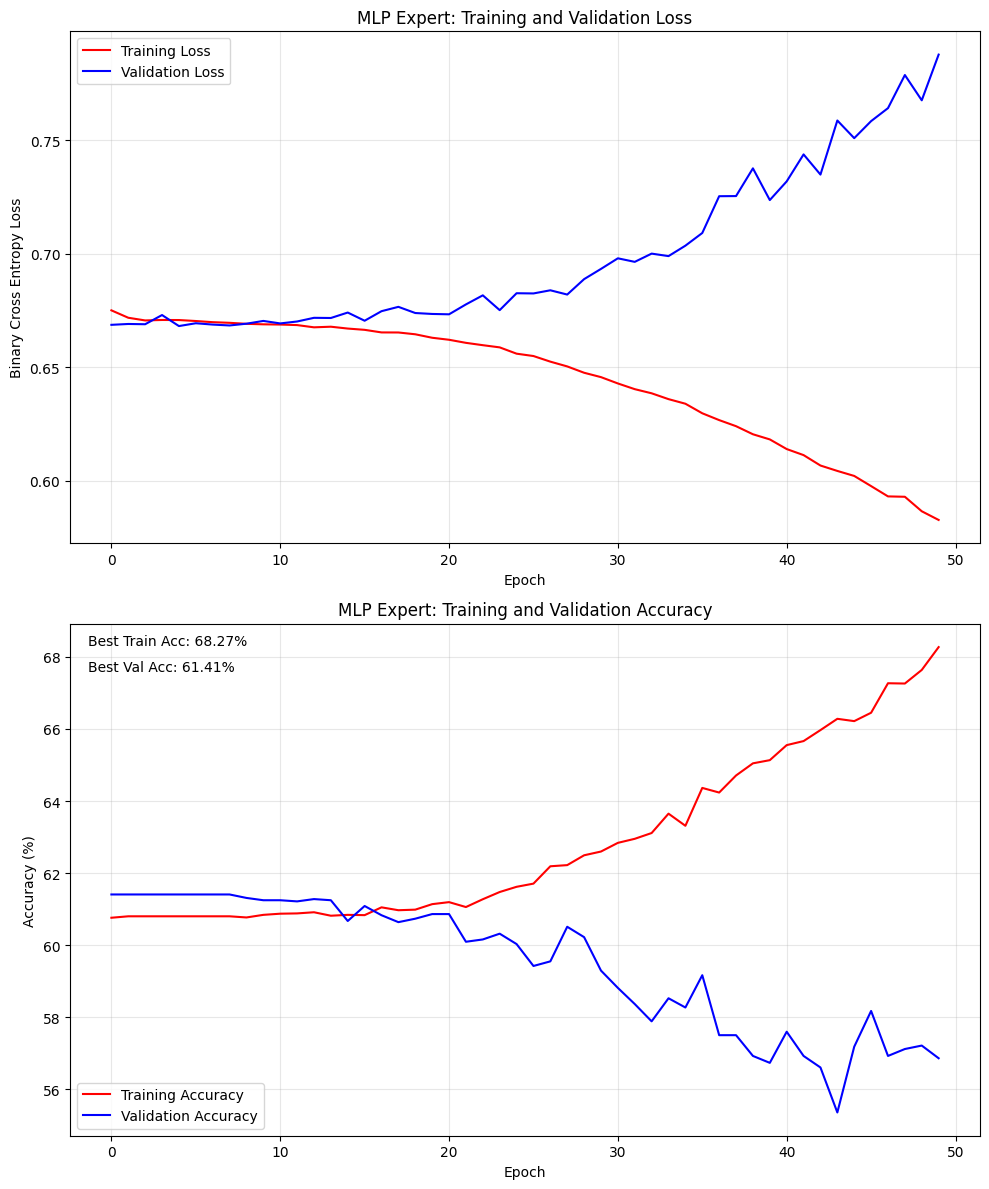

In [12]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot losses
ax1.plot(train_metrics['train_losses'], label='Training Loss', color='red')
if train_metrics['val_losses']:
    ax1.plot(train_metrics['val_losses'], label='Validation Loss', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Binary Cross Entropy Loss')
ax1.set_title('MLP Expert: Training and Validation Loss')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot accuracies
ax2.plot(train_metrics['train_accuracies'], label='Training Accuracy', color='red')
if train_metrics['val_accuracies']:
    ax2.plot(train_metrics['val_accuracies'], label='Validation Accuracy', color='blue')
    
# Add best accuracies as text
best_train_acc = max(train_metrics['train_accuracies'])
ax2.text(0.02, 0.98, f'Best Train Acc: {best_train_acc:.2f}%', 
         transform=ax2.transAxes, verticalalignment='top')
if train_metrics['val_accuracies']:
    best_val_acc = max(train_metrics['val_accuracies'])
    ax2.text(0.02, 0.93, f'Best Val Acc: {best_val_acc:.2f}%',
             transform=ax2.transAxes, verticalalignment='top')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('MLP Expert: Training and Validation Accuracy')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()